In [ ]:
import time
#time.sleep(60*60*8)

import numpy as np
from numpy import asarray
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, regularizers, layers, optimizers, losses, metrics
from tensorflow.keras.layers import Dense, Dropout, Flatten, LeakyReLU, Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.python.client import device_lib
import tensorflow.compat.v1.keras.backend as K
import tensorflow.compat.v1 as tf1

import cv2
import matplotlib.pyplot as plt
from PIL import Image
import imgaug.augmenters as iaa
from skimage import data, color, img_as_ubyte ,io
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
from skimage.color import rgb2gray,rgba2rgb

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, classification_report,roc_auc_score,ConfusionMatrixDisplay
from sklearn.utils import class_weight
import imutils
import os
import random
from tqdm import tqdm
import urllib.request


tf.keras.backend.clear_session()
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
strategy = tf.distribute.MirroredStrategy()

from classification_models.tfkeras import Classifiers
Resnext, preprocess_input = Classifiers.get('resnext50')

In [ ]:
def decode(a):
    if a =='A' or a =='2':
        return int(2)
    elif  a=='B' or a == '1':
        return int(1)
    elif a=='C' or a =='0':
        return int(0)
    else:
        return int(a)

    
def to_categorical(y, num_classes=None, dtype='float32'):

 
    y = np.array(y, dtype='int')

    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])

    y = y.ravel()

    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]

    categorical = np.zeros((n, num_classes), dtype=dtype)

    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

def label_smoothing(y, num_classes=3, dtype='float32',factor=0.3):
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
         input_shape = tuple(input_shape[:-1])

    y = y.ravel()
    if not num_classes:
         num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)

    for i in np.arange(n):
        if y[i]-1>=0 and y[i]+1<num_classes:
            categorical[np.arange(n), y] = 1-factor
            categorical[i, y[i]-1] = factor/2
            categorical[i, y[i]+1] = factor/2
        elif y[i]-1>=0 and y[i]+1>=num_classes:
            categorical[np.arange(n), y] = 1-factor
            categorical[i, y[i]-1] = factor
        else:
            categorical[np.arange(n), y] = 1-factor
            categorical[i, y[i]+1] = factor
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical
        
        

In [3]:
#input     
fine= pd.read_csv('/mnt/louisayu/nfs_share2/embryo/code/em_aug/grading/fresh.csv')  
train=pd.read_csv("/mnt/louisayu/nfs_share2/embryo/code/em_aug/grading/Gardner_train_silver.csv")
test=pd.read_csv("/mnt/louisayu/nfs_share2/embryo/code/em_aug/grading/Gardner_test_gold_onlyGardnerScores.csv")

pixel=256
channels=3
NUM_CLASSES=5

fine_image=[]
fine_label=[]

train_image = []
train_label = []

test_image=[]
test_label=[]
testname=[]


for i in tqdm(range(fine.shape[0])):
    filename= "/mnt/louisayu/nfs_share2/embryo/preprocess_rec/"+fine['image'][i]
    if not fine['g2'][i]=='ND':
        try:
            im = cv2.imread(filename)#,cv2.IMREAD_GRAYSCALE)
            im = cv2.resize(im,(pixel,pixel))
            im = cv2.normalize(im, None, 0, 255, norm_type=cv2.NORM_MINMAX)
            img = img_to_array(im)
            fine_label.append(decode(fine['g2'][i]))
            fine_image.append(img)
        except:
            print("fine:", filename)
        
for j in tqdm(range(train.shape[0])):
    filename= "/mnt/louisayu/nfs_share2/embryo/pubdata/"+train['Image'][j]
    if not train['g2'][j]=='ND':
        try:  
            im = cv2.imread(filename)#,cv2.IMREAD_GRAYSCALE)
            im = cv2.resize(im,(pixel,pixel))
            im = cv2.normalize(im, None, 0, 255, norm_type=cv2.NORM_MINMAX)
            #im = cv2.copyMakeBorder(im, 32, 32, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))
            img = img_to_array(im)
            train_label.append(decode(train['g2'][j]))
            train_image.append(img)
        except:
            print("train:", filename)
                
for k in tqdm(range(test.shape[0])):
    filename= "/mnt/louisayu/nfs_share2/embryo/pubdata/"+test['Image'][k]
    if not test['g2'][k]=='NA' and not test['g2'][k]=='ND':
        try:   
            im = cv2.imread(filename)#,cv2.IMREAD_GRAYSCALE)
            im = cv2.resize(im,(pixel,pixel))
            im = cv2.normalize(im, None, 0, 255, norm_type=cv2.NORM_MINMAX)
            #im = cv2.copyMakeBorder(im, 32, 32, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))
            img = img_to_array(im)
            test_label.append(decode(test['g2'][k]))
            test_image.append(img)
            testname.append(test['Image'][k])
        except:
            print("test:", filename)

 85%|████████████████████████████████████████████▎       | 405/475 [00:01<00:00, 201.10it/s][ WARN:0@3.566] global loadsave.cpp:248 findDecoder imread_('/mnt/louisayu/nfs_share2/embryo/preprocess_rec/20200713 LYT.bmp'): can't open/read file: check file path/integrity
[ WARN:0@3.566] global loadsave.cpp:248 findDecoder imread_('/mnt/louisayu/nfs_share2/embryo/preprocess_rec/20210329 AUYK.bmp'): can't open/read file: check file path/integrity
[ WARN:0@3.566] global loadsave.cpp:248 findDecoder imread_('/mnt/louisayu/nfs_share2/embryo/preprocess_rec/20220501 LKM.jpg'): can't open/read file: check file path/integrity
100%|████████████████████████████████████████████████████| 475/475 [00:01<00:00, 296.20it/s]


fine: /mnt/louisayu/nfs_share2/embryo/preprocess_rec/20200713 LYT.bmp
fine: /mnt/louisayu/nfs_share2/embryo/preprocess_rec/20210329 AUYK.bmp
fine: /mnt/louisayu/nfs_share2/embryo/preprocess_rec/20220501 LKM.jpg


 15%|███████▉                                             | 45/300 [00:00<00:01, 187.11it/s]

test: /mnt/louisayu/nfs_share2/embryo/pubdata/0020_02.png
test: /mnt/louisayu/nfs_share2/embryo/pubdata/0036_05.png


 34%|█████████████████▌                                  | 101/300 [00:00<00:01, 171.78it/s]

test: /mnt/louisayu/nfs_share2/embryo/pubdata/0167_01.png


 46%|███████████████████████▉                            | 138/300 [00:00<00:00, 174.35it/s]

test: /mnt/louisayu/nfs_share2/embryo/pubdata/292_03.png


 76%|███████████████████████████████████████▌            | 228/300 [00:01<00:00, 167.75it/s]

test: /mnt/louisayu/nfs_share2/embryo/pubdata/511_01.png


 93%|████████████████████████████████████████████████▌   | 280/300 [00:01<00:00, 163.44it/s]

test: /mnt/louisayu/nfs_share2/embryo/pubdata/677_01.png
test: /mnt/louisayu/nfs_share2/embryo/pubdata/824_02.png


100%|████████████████████████████████████████████████████| 300/300 [00:01<00:00, 168.12it/s]

test: /mnt/louisayu/nfs_share2/embryo/pubdata/833_02.png


In [4]:
     
a0= [x for x, y in list(enumerate(train_label)) if y ==0]
a1= [x for x, y in list(enumerate(train_label)) if y ==1]
a2= [x for x, y in list(enumerate(train_label)) if y ==2]

print("before aug, a0:",len(a0))
print("before aug, a1:",len(a1))
print("before aug, a2:",len(a2))    


before aug, a0: 16
before aug, a1: 332
before aug, a2: 1305


In [5]:
#augmentation
import imgaug.augmenters as iaa

sometimes = lambda aug: iaa.Sometimes(0.5, aug)  
seq= iaa.Sequential([
    iaa.SomeOf((1, 3),
               [
    sometimes(iaa.CoarseSaltAndPepper(0.05, size_percent=(0.01, 0.1))),
    iaa.GammaContrast((0.1)),
    iaa.MotionBlur(k=15),
    sometimes(iaa.Emboss(alpha=(0.0, 1.0), strength=(0.5, 1.5))),
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}), # translate by -20 to +20 percent (per axis)),
    iaa.pillike.EnhanceSharpness()],
            random_order=True)
])
seq1=iaa.Sequential([
    iaa.SomeOf((2, 3),
               [
    iaa.GaussianBlur(sigma=(0.0, 3.0)),
    iaa.GammaContrast((0.1)),
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}), # translate by -20 to +20 percent (per axis)),
    iaa.pillike.EnhanceSharpness()],
            random_order=True)
])
    
    
img0=[]
for i in a0:
    img0.append(train_image[i].astype(np.uint8))
    
img1=[]
for i in a1:
    img1.append(train_image[i].astype(np.uint8))
print(len(img0),len(img1))

img0seq = seq(images=img0)
train_image.extend(img0seq)
img0seq1=  seq1(images=img0) 
train_image.extend(img0seq1)  
for i in range(len(img0seq)):
    train_label.append(0)
for i in range(len(img0seq1)):
    train_label.append(0)
    
img1seq = seq(images=img1)
train_image.extend(img1seq)
for i in range(len(img1seq)):
    train_label.append(1)
    
img1seq1 = seq1(images=img1)
train_image.extend(img1seq1)
for i in range(len(img1seq1)):
    train_label.append(1)

        
a0= [x for x, y in list(enumerate(train_label)) if y ==0]
a1= [x for x, y in list(enumerate(train_label)) if y ==1]
a2= [x for x, y in list(enumerate(train_label)) if y ==2]

print("after aug, a0:",len(a0))
print("after aug, a1:",len(a1))
print("after aug, a2:",len(a2))    



16 332
after aug, a0: 48
after aug, a1: 996
after aug, a2: 1305


In [6]:
#preprocess input
xtrain = np.array(train_image,dtype='float32')  
ytrain = np.array(train_label)

X_train, X_val, Y_train, Y_val = train_test_split(xtrain, ytrain, shuffle=True,random_state=42, test_size=0.15)

y_train= to_categorical(Y_train,3)
y_val=to_categorical(Y_val,3)


In [56]:
#model
def ordinal_loss(y_true,y_pred):
    #y_true = tf.cast(y_true, dtype=tf.int256)
    weights= K.cast(K.abs(K.argmax(y_true,axis=1)-K.argmax(y_pred,axis=1)),dtype='float32')
    return (1+weights)*tf.keras.losses.categorical_crossentropy(y_true,y_pred)

# # with strategy.scope():
# vit_model = vit.vit_b16(
#         image_size = 224,
#         activation = 'linear',
#         pretrained = True,
#         include_top = True,
#         pretrained_top =True,)
#         #classes = 3)

resnext50 = Resnext((224, 224, 3),include_top=True, weights='imagenet')
model = Sequential([
        layers.Input(shape=(pixel,pixel,channels),name='main_input'),
        layers.Resizing(224, 224),
        layers.RandomRotation(factor=(-0.2, 0.3)),
        # layers.RandomZoom(height_factor=-0.1, width_factor=-0.1),
        layers.RandomFlip(mode="horizontal_and_vertical"),
        layers.BatchNormalization(),
        # vit_model,
        resnext50,
        layers.Dense(3,activation='softmax'),
    ],
    name = 'resnext50_icm')

from keras import backend as K

opt = tf.keras.optimizers.Adam(learning_rate=0.00003)
model.compile(optimizer=opt,  loss=ordinal_loss, metrics =['accuracy', tf.keras.metrics.AUC(multi_label = True, name='aucc')]) 

print(model.summary())


def get_callbacks():
    checkpoint_filepath = '/mnt/louisayu/nfs_share2/embryo/model_weights1/g2/ep{epoch:03d}_acc{val_accuracy:.4f}_val_loss{val_loss:.4f}.h5'
    return [
            EarlyStopping(monitor="val_accuracy", mode="max", patience = 15, verbose=1, restore_best_weights=True),
            
            ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.8, min_lr=1e-6, patience=7, verbose=1),
            
            ModelCheckpoint(checkpoint_filepath, monitor="val_accuracy", mode="max", save_weights_only=True) # save_best_only=True)
           ]

from sklearn.utils import class_weight
y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

history=model.fit(X_train, y_train, batch_size= 32, validation_data=(X_val, y_val), epochs=80, verbose=2, shuffle=True,callbacks=get_callbacks(),class_weight=d_class_weights)

Model: "resnext50_icm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
model_2 (Functional)         (None, 1000)              25097137  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3003      
Total params: 25,100,152
Trainable params: 25,031,916
Non-trainable params: 68,236
____________________________________

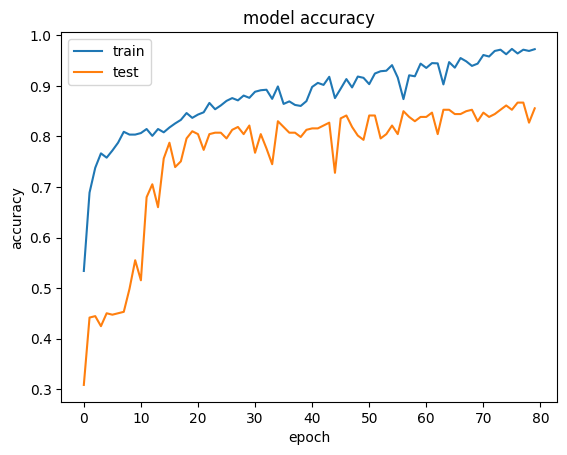

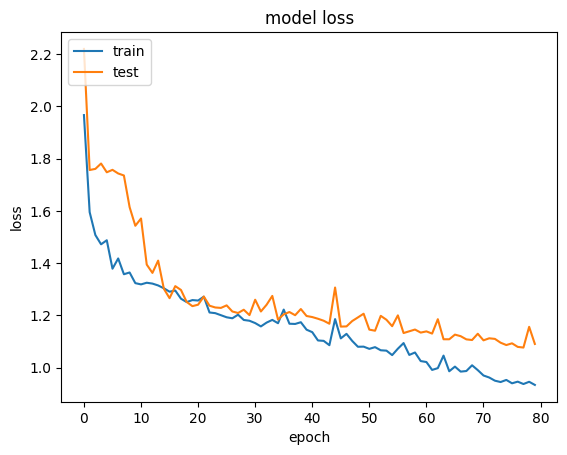

In [11]:
#Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
    

roc_auc_score: 0.7018374343201333
f1_score: 0.7233338477351278
accuracy_score: 0.7478991596638656
              precision    recall  f1-score   support

           0       0.25      0.06      0.10        17
           1       0.62      0.56      0.59        68
           2       0.80      0.91      0.85       153

    accuracy                           0.75       238
   macro avg       0.56      0.51      0.51       238
weighted avg       0.71      0.75      0.72       238



/mnt/louisayu/nfs_share2/anaconda3/envs/tf/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


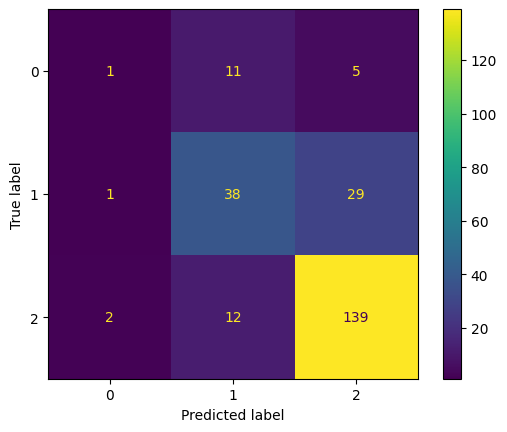

In [183]:
x_test = np.reshape(test_image,(len(test_label),pixel,pixel,channels))
y_test = np.reshape(test_label,(len(test_label),1))

y_prediction=model.predict(x_test)
score = roc_auc_score(y_test, y_prediction, multi_class='ovr')
print("roc_auc_score:", score)
y_prediction = np.argmax(y_prediction, axis=1)
print("f1_score:", f1_score(y_test, y_prediction, average='weighted'))   
ac=accuracy_score(y_test, y_prediction)
print("accuracy_score:", ac)
print(classification_report(y_test, y_prediction))

model.save('/mnt/louisayu/nfs_share2/embryo/model_weights1/g2/model/'+str(ac).replace('0.','')+'.h5')
cm=confusion_matrix(y_test, y_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [164]:
ft_image=np.array((train_image+fine_image),dtype='float32')
ft_label=np.concatenate((to_categorical(train_label,3),label_smoothing(fine_label,3)),axis=0)

index = [i for i in range(len(ft_label))]
np.random.seed(27)
np.random.shuffle(index)
x_fine = ft_image[index]
y_fine = ft_label[index]
X_fine= np.reshape(x_fine,(len(x_fine),pixel,pixel,channels))

ftmodel=tf.keras.models.load_model("/mnt/louisayu/nfs_share2/embryo/model_weights1/g2/model/7478991596638656.h5",compile=False)

opt = tf.keras.optimizers.Adam(learning_rate=0.00006)
ftmodel.compile(optimizer=opt,  loss= ordinal_loss, metrics =['accuracy', tf.keras.metrics.AUC(multi_label = True, name="auc")]) 



def get_callbacks():
    checkpoint_filepath = '/mnt/louisayu/nfs_share2/embryo/model_weights1/g2/ep{epoch:03d}_acc{accuracy:.4f}_val_loss{loss:.4f}.h5'
    return [
            EarlyStopping(monitor="val_accuracy", mode="max", patience = 6, verbose=1, restore_best_weights=True),
            
            ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.9, min_lr=1e-6, patience=3, verbose=1),
            
            ModelCheckpoint(checkpoint_filepath, monitor="val_accuracy", mode="max", save_weights_only=True) # save_best_only=True)
           ]

y_integers = np.argmax(y_fine, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

history=ftmodel.fit(X_fine, y_fine, batch_size=32, epochs=50, verbose=2, shuffle=True,callbacks=get_callbacks(),class_weight=d_class_weights, validation_split=0.12)

{0: 16.43452380952381, 1: 0.7315845257021728, 2: 0.6360285648468095}
Epoch 1/50
76/76 - 41s - loss: 1.4702 - accuracy: 0.6991 - auc: 0.7835 - val_loss: 1.3277 - val_accuracy: 0.7169 - val_auc: 0.6593
Epoch 2/50
76/76 - 16s - loss: 1.3858 - accuracy: 0.6982 - auc: 0.7986 - val_loss: 1.2022 - val_accuracy: 0.7771 - val_auc: 0.8059
Epoch 3/50
76/76 - 17s - loss: 1.3160 - accuracy: 0.7283 - auc: 0.7971 - val_loss: 1.2457 - val_accuracy: 0.7470 - val_auc: 0.7869
Epoch 4/50
76/76 - 16s - loss: 1.2682 - accuracy: 0.7760 - auc: 0.8093 - val_loss: 1.2011 - val_accuracy: 0.7741 - val_auc: 0.8098
Epoch 5/50
76/76 - 16s - loss: 1.2732 - accuracy: 0.7415 - auc: 0.8069 - val_loss: 1.1982 - val_accuracy: 0.7741 - val_auc: 0.8219
Epoch 6/50
76/76 - 17s - loss: 1.2702 - accuracy: 0.7793 - auc: 0.8270 - val_loss: 1.1929 - val_accuracy: 0.7922 - val_auc: 0.8525
Epoch 7/50
76/76 - 17s - loss: 1.3724 - accuracy: 0.7402 - auc: 0.8433 - val_loss: 1.1481 - val_accuracy: 0.8163 - val_auc: 0.8168
Epoch 8/50
76/

roc_auc_score: 0.7152840623428859
f1_score: 0.7574031971749426
accuracy_score: 0.7647058823529411
              precision    recall  f1-score   support

           0       0.43      0.18      0.25        17
           1       0.60      0.72      0.66        68
           2       0.87      0.85      0.86       153

    accuracy                           0.76       238
   macro avg       0.63      0.58      0.59       238
weighted avg       0.76      0.76      0.76       238



/mnt/louisayu/nfs_share2/anaconda3/envs/tf/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


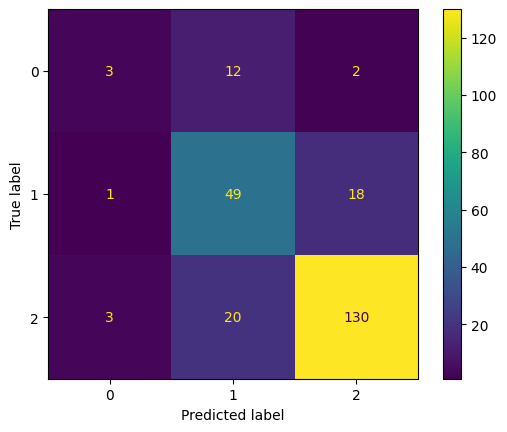

In [181]:
x_test = np.reshape(test_image,(len(test_label),pixel,pixel,channels))
y_test = np.reshape(test_label,(len(test_label),1))


y_prediction=ftmodel.predict(x_test)
score = roc_auc_score(y_test, y_prediction, multi_class='ovr')
print("roc_auc_score:", score)
y_prediction = np.argmax(y_prediction, axis=1)
print("f1_score:", f1_score(y_test, y_prediction, average='weighted'))   
ac=accuracy_score(y_test, y_prediction)
print("accuracy_score:", ac)
print(classification_report(y_test, y_prediction))

ftmodel.save('/mnt/louisayu/nfs_share2/embryo/model_weights1/g2/model/ft_'+str(ac).replace('0.','')+'.h5')
cm=confusion_matrix(y_test, y_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [206]:
ft_image=np.array((train_image+fine_image),dtype='float32')
ft_label=np.concatenate((to_categorical(train_label,3),to_categorical(fine_label,3)),axis=0)

index = [i for i in range(len(ft_label))]
np.random.seed(27)
np.random.shuffle(index)
x_fine = ft_image[index]
y_fine = ft_label[index]
X_fine= np.reshape(x_fine,(len(x_fine),pixel,pixel,channels))

combine_model=tf.keras.models.load_model("/mnt/louisayu/nfs_share2/embryo/model_weights1/g2/model/7478991596638656.h5",compile=False)

opt = tf.keras.optimizers.Adam(learning_rate=0.00006)
combine_model.compile(optimizer=opt,  loss= ordinal_loss, metrics =['accuracy', tf.keras.metrics.AUC(multi_label = True, name="auc")]) 



def get_callbacks():
    checkpoint_filepath = '/mnt/louisayu/nfs_share2/embryo/model_weights1/g2/ep{epoch:03d}_acc{accuracy:.4f}_val_loss{loss:.4f}.h5'
    return [
            EarlyStopping(monitor="val_accuracy", mode="max", patience = 6, verbose=1, restore_best_weights=True),
            
            ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.9, min_lr=1e-6, patience=3, verbose=1),
            
            ModelCheckpoint(checkpoint_filepath, monitor="val_accuracy", mode="max", save_weights_only=True) # save_best_only=True)
           ]

y_integers = np.argmax(y_fine, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

history=combine_model.fit(X_fine, y_fine, batch_size=32, epochs=50, verbose=2, shuffle=True,callbacks=get_callbacks(),class_weight=d_class_weights, validation_split=0.12)

{0: 16.43452380952381, 1: 0.7315845257021728, 2: 0.6360285648468095}
Epoch 1/50
76/76 - 41s - loss: 1.3564 - accuracy: 0.7131 - auc: 0.8519 - val_loss: 1.2416 - val_accuracy: 0.7440 - val_auc: 0.8903
Epoch 2/50
76/76 - 17s - loss: 1.3358 - accuracy: 0.7098 - auc: 0.8764 - val_loss: 1.1649 - val_accuracy: 0.8012 - val_auc: 0.7880
Epoch 3/50
76/76 - 17s - loss: 1.3558 - accuracy: 0.6867 - auc: 0.8638 - val_loss: 1.2220 - val_accuracy: 0.7711 - val_auc: 0.7815
Epoch 4/50
76/76 - 17s - loss: 1.3812 - accuracy: 0.6472 - auc: 0.8500 - val_loss: 1.2450 - val_accuracy: 0.7500 - val_auc: 0.8412
Epoch 5/50
76/76 - 17s - loss: 1.2579 - accuracy: 0.7192 - auc: 0.8877 - val_loss: 1.2331 - val_accuracy: 0.7590 - val_auc: 0.8619

Epoch 00005: ReduceLROnPlateau reducing learning rate to 5.399999863584526e-05.
Epoch 6/50
76/76 - 17s - loss: 1.2873 - accuracy: 0.7633 - auc: 0.8901 - val_loss: 1.1686 - val_accuracy: 0.7982 - val_auc: 0.8780
Epoch 7/50
76/76 - 17s - loss: 1.2445 - accuracy: 0.7530 - auc: 

roc_auc_score: 0.5987759885251235
f1_score: 0.6542548685342001
accuracy_score: 0.7100840336134454
              precision    recall  f1-score   support

           0       0.40      0.12      0.18        17
           1       0.72      0.26      0.39        68
           2       0.72      0.97      0.83       153

    accuracy                           0.71       238
   macro avg       0.61      0.45      0.46       238
weighted avg       0.69      0.71      0.65       238



/mnt/louisayu/nfs_share2/anaconda3/envs/tf/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


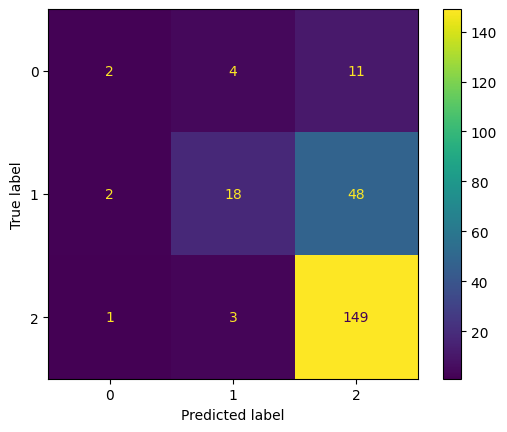

In [207]:
x_test = np.reshape(test_image,(len(test_label),pixel,pixel,channels))
y_test = np.reshape(test_label,(len(test_label),1))


y_prediction=combine_model.predict(x_test)
score = roc_auc_score(y_test, y_prediction, multi_class='ovr')
print("roc_auc_score:", score)
y_prediction = np.argmax(y_prediction, axis=1)
print("f1_score:", f1_score(y_test, y_prediction, average='weighted'))   
ac=accuracy_score(y_test, y_prediction)
print("accuracy_score:", ac)
print(classification_report(y_test, y_prediction))

combine_model.save('/mnt/louisayu/nfs_share2/embryo/model_weights1/g2/model/cm_'+str(ac).replace('0.','')+'.h5')
cm=confusion_matrix(y_test, y_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [ ]:
for k in range(test.shape[0]):
    filename= "/mnt/louisayu/nfs_share2/embryo/pubdata/"+test['Image'][k]
      
    im = cv2.imread(filename)#,cv2.IMREAD_GRAYSCALE)
    im = cv2.resize(im,(pixel,pixel))
    im = cv2.normalize(im, None, 0, 255, norm_type=cv2.NORM_MINMAX)
    #im = cv2.copyMakeBorder(im, 32, 32, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))
    img = img_to_array(im)
    print(np.argmax(model.predict(np.reshape(img,(1,pixel,pixel,channels)))))


In [ ]:
for k in range(test.shape[0]):
    filename= "/mnt/louisayu/nfs_share2/embryo/pubdata/"+test['Image'][k]
      
    im = cv2.imread(filename)#,cv2.IMREAD_GRAYSCALE)
    im = cv2.resize(im,(pixel,pixel))
    im = cv2.normalize(im, None, 0, 255, norm_type=cv2.NORM_MINMAX)
    #im = cv2.copyMakeBorder(im, 32, 32, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))
    img = img_to_array(im)
    print(np.argmax(ftmodel.predict(np.reshape(img,(1,pixel,pixel,channels)))))


In [ ]:
for k in range(test.shape[0]):
    filename= "/mnt/louisayu/nfs_share2/embryo/pubdata/"+test['Image'][k]
      
    im = cv2.imread(filename)#,cv2.IMREAD_GRAYSCALE)
    im = cv2.resize(im,(pixel,pixel))
    im = cv2.normalize(im, None, 0, 255, norm_type=cv2.NORM_MINMAX)
    #im = cv2.copyMakeBorder(im, 32, 32, 0, 0, cv2.BORDER_CONSTANT, value=(0,0,0))
    img = img_to_array(im)
    print(np.argmax(combine_model.predict(np.reshape(img,(1,pixel,pixel,channels)))))
